# 逆伝播のイメージ

以下は、計算グラフによる逆伝播のイメージ。

![画像を表示できません。](image.jpeg)

## 連鎖律

$$\dfrac{\partial L}{\partial x}=\dfrac{\partial L}{\partial t} \dfrac{\partial t}{\partial x}$$

$x$ に関する$L$の微分は、「 $t$ に関する$L$の微分」と「 $x$ に関する $t$ の微分」の積で表すことができる。<br>
逆方向に、局所的な微分の値を乗算していくことで、それぞれの変数の微分の値が得られる。

## 加算ノード

$L=x+y+z$ について<br>
$$\dfrac{\partial L}{\partial x}=1,\quad \dfrac{\partial L}{\partial y}=1,\quad \dfrac{\partial L}{\partial z}=1$$

上流から伝わった値に、1を乗算して下流に流す。すなわち伝わった微分の値を次のノードへ流すだけ。

## 乗算ノード

$L=xyz$ について
$$\dfrac{\partial L}{\partial x}=yz,\quad \dfrac{\partial L}{\partial y}=zx,\quad \dfrac{\partial L}{\partial z}=xy$$

上流から伝わった値に、順伝播の際の入力信号のうち、自分の値を除いた値の積を乗算して下流に流す。

# レイヤの実装

## 逆伝播のイメージ

上のイメージをPythonで実装する。

### 加算レイヤ

In [1]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

### 乗算レイヤ

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

### 行列乗算レイヤ

In [1]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW # Numpy配列上のメモリ位置を固定した上で、要素を上書き
        return dx

### 実装

In [3]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## 活性化関数レイヤ

ニューラルネットワークを構成する「層（レイヤ）」を実装する。

### ReLUレイヤ

ReLU（Rectified Linear Unit）
$$y=\begin{cases}
    x & (x > 0) \\
    0 & (x \leqq 0)
  \end{cases}$$
$x$に関する$y$の微分は以下のようになる。
$$\dfrac{\partial y}{\partial x}=\begin{cases}
    1 & (x > 0) \\
    0 & (x \leqq 0)
  \end{cases}$$

順伝播時に、$x$ が0以下であれば、逆伝播では、下流への信号はストップする。<br>
つまりReLUレイヤは、回路における「**スイッチ**」のように機能する。

In [4]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

逆伝播では、順伝播時に保持した`mask`を使って、逆伝播された`dout`に対し、`mask`の要素が`True`（すなわち負の値）の場所を`0`に設定する。

### Sigmoidレイヤ

$$y=\dfrac{1}{1+\exp \left( -x\right) }$$

step5「 $x$ 」　→　　step4「 $-x$ 」　→　　step3「 $\exp(-x)$ 」　→　　step2「 $1+\exp(-x)$ 」　→　　step1「 $\dfrac{1}{1+\exp \left( -x\right) }(=y)$ 」

> **導出**

>**step1**
>
>最終的な値$L$を、シグモイド間数の出力 $y$ で微分する。
>$$\dfrac{\partial L}{\partial y}\tag{1}$$

>**step2**
>
>逆数を返す $b=\dfrac{1}{a}$ この式の微分は、次の式で表される。
>$\dfrac{\partial b}{\partial a} = -a^{-2} =-b^{2}$
>
>順伝播の出力の2乗に、マイナスを付けた値を乗算。
>$$-\dfrac{\partial L}{\partial y}y^{2}\tag{2}$$

>**step3**
>
>1を加える加算ノードでは、値をそのまま流す。
>$$-\dfrac{\partial L}{\partial y}y^{2}\tag{3}$$

>**step4**
>
>$b=\exp(a)$ この式の微分は、次の式で表される。$\dfrac{\partial b}{\partial a}=\exp \left( a\right)$
>
>ネイピア数の、順伝播時の入力の値乗（順伝播時の出力値）を乗算。
>$$-\dfrac{\partial L}{\partial y}y^{2}\exp \left( -x\right) \tag{4}$$

>**step5**
>
>順伝播の際の入力信号のうち、自分の値を除いた値の積（-1）を乗算し、変形。<br><br>
>$$\begin{align}
\dfrac{\partial L}{\partial y}y^{2}\exp \left( -x\right)
&= \dfrac{\partial L}{\partial y}\dfrac{1}{\lbrace(1+\exp \left( -x\right)\rbrace^{2}} \exp \left( -x\right)\\\\
&= \dfrac{\partial L}{\partial y}\dfrac{1}{1+\exp \left( -x\right)} \dfrac{\exp \left( -x\right)}{1+\exp \left( -x\right)}\\\\
&= \dfrac{\partial L}{\partial y}y\left( 1-y\right) \tag{5} 
\end{align}$$<br>
>Sigmoidレイヤの逆伝播は、順伝播の出力だけ（`x`を使わずに`y`のみ）から、シンプルに計算できる。

In [21]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

順伝播時の出力を`out`に保持し、逆伝播時に`out`を使って計算する。

## Affineレイヤ

$\mathrm{X}\cdot \mathrm{W}=\mathrm{Y}$（多次元配列）について
$$\dfrac{\partial L}{\partial \mathrm{X}}=\dfrac{\partial L}{\partial \mathrm{Y}} \cdot \mathrm{W}^\mathsf{T},\quad 
\dfrac{\partial L}{\partial \mathrm{W}}=\mathrm{X}^\mathsf{T} \cdot \dfrac{\partial L}{\partial \mathrm{Y}}$$
$\mathsf{T}$は転置を表し、次元数を揃えるために転置を行う。

In [6]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

## Softmax-with-Lossレイヤ

ここでは、交差エントロピー誤差も含めて実装する。

![画像を表示できません。](image2.jpeg)

分類問題において<br>
「**ソフトマックス関数**」の損失関数に「**交差エントロピー誤差**」を用いると、逆伝播が $(y_1-t_1, \quad y_2-t_2, \quad y_3-t_3)$ とキレイな結果になる。<br><br>
回帰問題において<br>
「**恒等関数**」の損失関数に「**二乗和誤差**」を用いると、逆伝播が $(y_1-t_1,\quad  y_2-t_2, \quad y_3-t_3)$ とキレイな結果になる。<br><br>
これらは偶然ではなく、逆伝播がキレイな値になるよう誤差関数が定義されたものである。

In [13]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

教師ラベル：$(0, 1, 0)$<br>
1. Softmaxレイヤの出力：$(0.3, 0.2, 0.5)$<br>
$(0.3, -0.8, 0.5)$という大きな誤差を伝播するため、これより前のレイヤが学習する内容は大きくなる。<br><br>
2. Softmaxレイヤの出力：$(0.01, 0.99, 0)$<br>
$(0.01, -0.01, 0)$という小さな誤差を伝播するため、これより前のレイヤが学習する内容は大きくなる。<br><br>
誤差の大きさによって、学習する量が変わるところが特徴。

# 誤差逆伝播法

レイヤを組み合わせることで、ニューラルネットワークを構築できる。

**ニューラルネットワークの全体像**
>1. ミニバッチ<br>
>訓練データの中からランダムに一部のデータを選び出す。<br><br>
>2. 勾配の算出（**誤差逆伝播法が活躍**）<br>
>各重みパラメータに関する損失関数の勾配を求める。<br><br>
>3. パラメータの更新<br>
>重みパラメータを勾配方向に微少量だけ更新する。<br><br>
>4. 繰り返し<br>
>1〜3を繰り返す。

**TwoLayerNetクラスのメソッド**

| メソッド | 説明 | 引数 |
|:------|:----|:----|
| `init(self, input_size, hidden_size, output_size)` |初期化|入力ニューロン数, 中間ニューロン数, 出力ニューロン数|
| `predict(self, x)` |認識（推論）|画像データ|
| `loss(self, x, t`) |損失関数|画像データ, 正解ラベル|
| `accuracy(self, x, t)` |認識精度|画像データ, 正解ラベル|
| `numerical_gradient(self, x, t)` |重みパラメータに対する勾配を求める|画像データ, 正解ラベル|
| `gradient(self, x, t)` |誤差逆伝播法|画像データ, 正解ラベル|

In [20]:
import numpy as np
from collections import OrderedDict

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [9]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## 勾配確認

In [14]:
from mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:5.836673595936918e-10
b1:2.7897869176655814e-09
W2:7.1059361108538524e-09
b2:1.4060401403725998e-07


数値微分と誤差逆伝播法でそれぞれ求めた勾配の差はかなり小さいことから、誤差逆伝播法の実装に誤りがないことになる。<br>
（コンピュータでは、有限の精度で計算（例えば32ビットの浮動小数点）が行われるため、誤差は0にならない。）

## 実装

In [17]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        
print("Done")

train acc, test acc | 0.08235, 0.0837
train acc, test acc | 0.9037166666666666, 0.9033
train acc, test acc | 0.9223, 0.9224
train acc, test acc | 0.9371333333333334, 0.9359
train acc, test acc | 0.9449666666666666, 0.941
train acc, test acc | 0.95195, 0.9491
train acc, test acc | 0.9569833333333333, 0.9524
train acc, test acc | 0.96135, 0.9565
train acc, test acc | 0.9642833333333334, 0.9571
train acc, test acc | 0.9664166666666667, 0.9608
train acc, test acc | 0.9691166666666666, 0.9638
train acc, test acc | 0.9722, 0.9655
train acc, test acc | 0.97325, 0.9672
train acc, test acc | 0.9749833333333333, 0.9661
train acc, test acc | 0.9762833333333333, 0.9678
train acc, test acc | 0.97735, 0.9685
train acc, test acc | 0.97905, 0.9699
Done


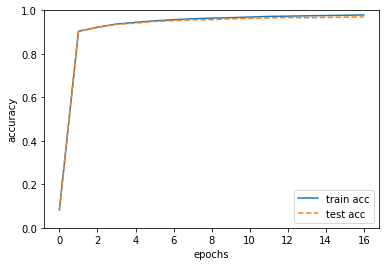

In [19]:
import matplotlib.pyplot as plt

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

エポックが進むにつれて、認識精度は向上している。<br>
また訓練データとテストデータの精度には差がほとんどなく、過学習が起きていない。